# Analyzing the impact of pruning on CNNs in TinyML applications on energy consumption.

This Jupyter notebook can be used to create pruned LeNet-5 like models, as defines in the paper.

In [2]:
import numpy as np
import os
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_model_optimization as tfmot
import kerassurgeon
import random

# Initialization

In [3]:
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Load FashionMNIST

In [4]:
load_data_result = tf.keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
batch_size = 64
img_height = 28
img_width = 28
img_channel = 1
number_of_classes = 10

In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# reshape dataset to have a single channel
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

print("Training:", len(train_images))
print("Testing:", len(test_images))

Training: 60000
Testing: 10000


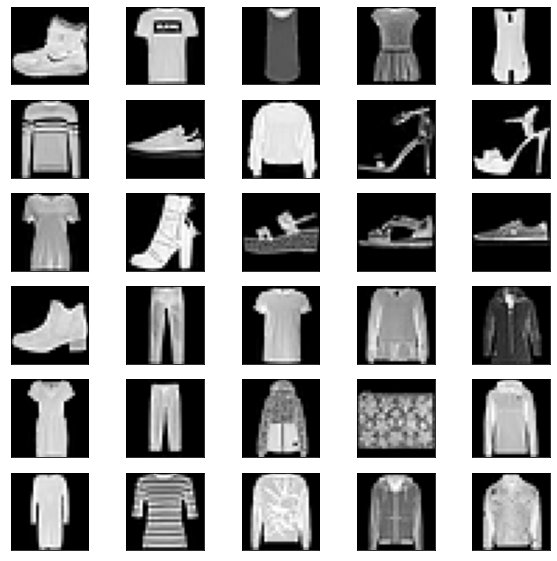

In [7]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.gray)
plt.show()

In [8]:
def create_lenet():
    model = keras.Sequential()
    model.add(layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu', input_shape=(img_width, img_height, img_channel), name="conv1"))
    model.add(layers.AveragePooling2D())
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name="conv2"))
    model.add(layers.AveragePooling2D())
    model.add(layers.Flatten(name="flatten1"))
    model.add(layers.Dense(units=120, activation='relu', name="dense1"))
    model.add(layers.Dense(units=84, activation='relu', name="dense2"))
    model.add(layers.Dense(units=number_of_classes, activation = 'softmax', name="dense3"))
    return model

def save_model(compression_rate, model_to_convert, type):
    path = "models/"
    if type == 0:
        path += "baseline/"
    elif type == 1:
        path += "structured_pruning/"
    elif type == 2:
        path += "unstructured_pruning/"
    else:
        model_to_convert = None

    (loss, accuracy) = model_to_convert.evaluate(test_images, test_labels)

    path += str(compression_rate)
    path += "_"
    path += str(loss)
    path += "_"
    path += str(accuracy)
    path += ".h5"

    print("Safe model to:", path)
    model_to_convert.save(path)


# Create the base model
The base model can either be created from scratch or loaded from the pre-trained model.

## Create base model from scratch

In [7]:
model = create_lenet()
model.summary()
model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy')
history = model.fit(train_images, train_labels, batch_size=batch_size, epochs=100, validation_data=(test_images, test_labels), callbacks=[callback])
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

model.evaluate(test_images, test_labels)

model.save("model.h5")

base_model = model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 12)        120       
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 12)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 11, 11, 32)        3488      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 32)          0         
_________________________________________________________________
flatten1 (Flatten)           (None, 800)               0         
_________________________________________________________________
dense1 (Dense)               (None, 120)               96120     
_________________________________________________________________
dense2 (Dense)               (None, 84)                1

2022-03-18 18:18:24.289519: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load pre-trained base model

In [336]:
base_model = tf.keras.models.load_model('model.h5')

# Pruning

Definition of all valid compression rates.
In the paper, CR is defined as:
$$
model\ compression:= \frac{\text{original number of parameters}}{\text{new number of parameters}}
$$

$$
CR:= 1 - \frac{1}{model\ compression}
$$

Here, CR_rates is equal to model compression.

In [337]:
CR_rates = np.array([1.5, 2, 3, 4, 8, 16, 24, 32, 48, 64])

# Unstructured pruning

This section is used to create the models pruned with unstructured pruning.
The output is a set of models compressed with the rates defined above.

## Unstructured pruning definition

In [338]:
unstructured_pruning_epochs = 2
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
validation_split = 0.1 # 10% of training set will be used for validation set. 
num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * unstructured_pruning_epochs
print("End step:", end_step)

End step: 1688


## Create models pruned with unstructured pruning

In [ ]:
for CR in CR_rates:
    CR_rate = 1 - (1 / CR)
    print("Create unstructured pruning model with CR:", CR, "=", CR_rate * 100, "%")
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=CR_rate, begin_step=0, end_step=end_step)
    }

    model_unstructure_pruned = prune_low_magnitude(base_model, **pruning_params)
    model_unstructure_pruned.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]
    model_unstructure_pruned.fit(train_images, train_labels, batch_size=batch_size, epochs=unstructured_pruning_epochs, callbacks=callbacks)
    model_unstructure_pruned_strip = tfmot.sparsity.keras.strip_pruning(model_unstructure_pruned)
    model_unstructure_pruned_strip.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
    save_model(CR, model_unstructure_pruned_strip, 2)

# Structured pruning

This section is used to create the models pruned with structured pruning.
The output is a set of models compressed with the rates defined above.

## Structured pruning definition

In [100]:
channels_allowed_for_pruning = ["conv1", "conv2", "dense1", "dense2"]

In [197]:
def prune_model(model, apoz_df, n_channels_delete):
    sorted_apoz_df = apoz_df.sort_values('apoz', ascending=False)
    high_apoz_index = sorted_apoz_df.iloc[0:n_channels_delete, :]

    surgeon = kerassurgeon.Surgeon(model, copy=True)
    for name in high_apoz_index.index.unique().values:
        channels = list(pd.Series(high_apoz_index.loc[name, 'index'],
                                  dtype=np.int64).values)

        print("Delete channels:", channels, "from layer:", name)
        surgeon.add_job('delete_channels', model.get_layer(name),
                        channels=channels)
    return surgeon.operate()


def get_total_channels(model):
    start = None
    end = None
    channels = 0
    for layer in model.layers[start:end]:
        if layer.name in channels_allowed_for_pruning:
            if layer.__class__.__name__ == 'Conv2D':
                channels += layer.filters
            else:
                channels += layer.units
    return channels


def get_model_apoz(model, generator):
    start = None
    end = None
    apoz = []
    for layer in model.layers[start:end]:
        if layer.name in channels_allowed_for_pruning:
            print(layer.name)
            apoz.extend([(layer.name, i, value) for (i, value)
                         in enumerate(kerassurgeon.identify.get_apoz(model, layer, generator))])

    layer_name, index, apoz_value = zip(*apoz)
    apoz_df = pd.DataFrame({'layer': layer_name, 'index': index,
                            'apoz': apoz_value})
    apoz_df = apoz_df.set_index('layer')
    return apoz_df

def get_layer_metadata(layer):
    parameters = 0
    channels = 0

    if layer.__class__ == tf.keras.layers.Conv2D:
        parameters = layer.count_params()
        channels = len(layer.get_weights()[0][0][0][0])
    elif layer.__class__ == tf.keras.layers.Dense:
        parameters = layer.count_params()
        channels = len(layer.get_weights()[0][0])

    #print("_____", layer.name, "_____")
    #print("Channels:", channels)
    #print("Parameters:", parameters)

    return (channels, parameters)



def get_number_of_channels(model):
    total_channels = 0
    for layer in model.layers:
        (channels, parameters) = get_layer_metadata(layer)
        total_channels += channels

    return total_channels

In [102]:
def get_model_metadata(model, CR, df_metadata):
    if CR == 0:
        CR_ratio = 0
    else:
        CR_ratio = 1 - (1 / CR)
    conv1 = model.get_layer("conv1")
    (conv1_channels, conv1_parameters) =  get_layer_metadata(conv1)
    conv2 = model.get_layer("conv2")
    (conv2_channels, conv2_parameters) =  get_layer_metadata(conv2)
    dense1 = model.get_layer("dense1")
    (dense1_channels, dense1_parameters) =  get_layer_metadata(dense1)
    dense2 = model.get_layer("dense2")
    (dense2_channels, dense2_parameters) =  get_layer_metadata(dense2)
    dense3 = model.get_layer("dense3")
    (dense3_channels, dense3_parameters) =  get_layer_metadata(dense3)
    (loss, accuracy) = model.evaluate(test_images, test_labels)
    trainable_parameters = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])

    tfliteconverter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = tfliteconverter.convert()
    model_size = len(tflite_model)

    if df_metadata.empty:
        df_metadata = pd.DataFrame(columns=["CR", 
                                            "CRPercent", 
                                            "loss", 
                                            "accuracy", 
                                            "size", 
                                            "parameters", 
                                            "channels_conv1", 
                                            "channels_conv2", 
                                            "channels_dense1", 
                                            "channels_dense2", 
                                            "channels_dense3"])

    return df_metadata.append({"CR": CR,
                               "CRPercent" : CR_ratio,
                               "loss" : loss,
                               "accuracy" : accuracy,
                               "size" : model_size,
                               "parameters" : trainable_parameters,
                               "channels_conv1" : conv1_channels,
                               "channels_conv2" : conv2_channels,
                               "channels_dense1" : dense1_channels,
                               "channels_dense2" : dense2_channels,
                               "channels_dense3" : dense3_channels}, 
                               ignore_index=True)

## Create models pruned with unstructured pruning

In [ ]:
model_structured_pruning = tf.keras.models.load_model('model.h5')
total_number_of_parameters = np.sum([np.prod(v.get_shape()) for v in model_structured_pruning.trainable_weights])
total_number_of_channels = get_number_of_channels(model_structured_pruning)
new_number_of_parameters = total_number_of_parameters
new_number_of_channels = total_number_of_channels
target_number_of_parameters = int(math.floor((1 - np.max(CR_rates)) * total_number_of_parameters))

target_CRs = CR_rates
targer_number_of_params_for_cr = np.floor((1 / CR_rates) * total_number_of_parameters)
target_number_of_parameters = int(np.min(targer_number_of_params_for_cr))

print(targer_number_of_params_for_cr)

print("Total parameters:", total_number_of_parameters, "Target:", target_number_of_parameters, "CR:", CR)
print("Total channels:", total_number_of_channels)

channels_per_cycle_percent = 0.01
channels_per_cycle = int(new_number_of_channels * channels_per_cycle_percent)

df_metadata = pd.DataFrame()
df_metadata = get_model_metadata(model_structured_pruning, 0, df_metadata)
df_metadata.to_csv(sep=';', index=None, path_or_buf="models/structured_pruning/pruning.csv")

ctn = 0
while len(target_CRs) > 0:
      ctn += channels_per_cycle
      print("Remove", channels_per_cycle, "channels...")
      apoz_df = get_model_apoz(model_structured_pruning, train_images[:5000])
      #print('pruning up to ', str(percent_pruned), '% of the original model weights')
      model_structured_pruning = prune_model(model_structured_pruning, apoz_df, channels_per_cycle)
      new_number_of_parameters = np.sum([np.prod(v.get_shape()) for v in model_structured_pruning.trainable_weights])
      new_number_of_channels = get_number_of_channels(model_structured_pruning)
      channels_per_cycle = max(int(new_number_of_channels * channels_per_cycle_percent), 1)
      progress = target_number_of_parameters / new_number_of_parameters
      print("Parameters:", new_number_of_parameters, "/", target_number_of_parameters, "Progress:", int(progress * 100), "%")

      if new_number_of_parameters < targer_number_of_params_for_cr[0]:
            CR_reached = target_CRs[0]
            print("Reached model target for CR:", CR_reached, "Parameters:", targer_number_of_params_for_cr[0])

            model_for_cr = tf.keras.models.clone_model(model_structured_pruning)
            model_for_cr.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
            model_for_cr.fit(train_images, train_labels, batch_size=batch_size, epochs=2)
            df_metadata = get_model_metadata(model_for_cr, CR_reached, df_metadata)
            df_metadata.to_csv(sep=';', index=None, path_or_buf="models/structured_pruning/pruning.csv")
            save_model(CR_reached, model_for_cr, 1)
            targer_number_of_params_for_cr = np.delete(targer_number_of_params_for_cr, 0)
            target_CRs = np.delete(target_CRs, 0)


# Create TFL model

This section converts a given tensorflow model into a TFL format suitable for the Raspberry Pi Pico.
Uncomment the wished model in the cells below.

### Basemodel

In [ ]:
#model_to_convert = tf.keras.models.load_model('models/baseline/1_0.3315724730491638_0.8928999900817871.h5')

### Unstructured pruning

In [ ]:
#model_to_convert = tf.keras.models.load_model('models/unstructured_pruning/1.5_0.3252561390399933_0.891700029373169.h5')
#model_to_convert = tf.keras.models.load_model('models/unstructured_pruning/2_0.3429083526134491_0.8878999948501587.h5')
#model_to_convert = tf.keras.models.load_model('models/unstructured_pruning/3_0.3318140208721161_0.8848000168800354.h5')
#model_to_convert = tf.keras.models.load_model('models/unstructured_pruning/4_0.3451225459575653_0.8779000043869019.h5')
#model_to_convert = tf.keras.models.load_model('models/unstructured_pruning/8_0.4504634141921997_0.8421000242233276.h5')
#model_to_convert = tf.keras.models.load_model('models/unstructured_pruning/16_0.6300343871116638_0.7609999775886536.h5')
#model_to_convert = tf.keras.models.load_model('models/unstructured_pruning/24_0.7002102732658386_0.7430999875068665.h5')
#model_to_convert = tf.keras.models.load_model('models/unstructured_pruning/32_0.8336520791053772_0.7156000137329102.h5')
#model_to_convert = tf.keras.models.load_model('models/unstructured_pruning/48_1.0612801313400269_0.6811000108718872.h5')
model_to_convert = tf.keras.models.load_model('models/unstructured_pruning/64_1.6582385301589966_0.42899999022483826.h5')

### Structured pruning

In [ ]:
#model_to_convert = tf.keras.models.load_model('models/structured_pruning/1.5_0.40001380443573_0.8611999750137329.h5')
#model_to_convert = tf.keras.models.load_model('models/structured_pruning/2.0_0.37604352831840515_0.8689000010490417.h5')
#model_to_convert = tf.keras.models.load_model('models/structured_pruning/3.0_0.3695162832736969_0.8722000122070312.h5')
#model_to_convert = tf.keras.models.load_model('models/structured_pruning/4.0_0.3817669153213501_0.8628000020980835.h5')
#model_to_convert = tf.keras.models.load_model('models/structured_pruning/8.0_0.4514373540878296_0.8331000208854675.h5')
#model_to_convert = tf.keras.models.load_model('models/structured_pruning/16.0_0.515175998210907_0.8228999972343445.h5')
#model_to_convert = tf.keras.models.load_model('models/structured_pruning/24.0_0.5242355465888977_0.8087000250816345.h5')
#model_to_convert = tf.keras.models.load_model('models/structured_pruning/32.0_0.5416665077209473_0.8044999837875366.h5')
#model_to_convert = tf.keras.models.load_model('models/structured_pruning/48.0_0.5723764300346375_0.7944999933242798.h5')
#model_to_convert = tf.keras.models.load_model('models/structured_pruning/64.0_0.6213505864143372_0.7741000056266785.h5')

# Convert model

In [278]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_to_convert)
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/vb/mchghtt9519g6bs7gqw029vm0000gn/T/tmpf0mj2qsn/assets


INFO:tensorflow:Assets written to: /var/folders/vb/mchghtt9519g6bs7gqw029vm0000gn/T/tmpf0mj2qsn/assets
2022-04-14 19:20:25.394128: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-04-14 19:20:25.394371: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-04-14 19:20:25.396320: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.002ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.

2022-04-14 19:20:25.684399: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-04-14 19:20:25.684417: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.


446468

In [279]:
import binascii

def convert_to_c_array(bytes) -> str:
  hexstr = binascii.hexlify(bytes).decode("UTF-8")
  hexstr = hexstr.upper()
  array = ["0x" + hexstr[i:i + 2] for i in range(0, len(hexstr), 2)]
  array = [array[i:i+10] for i in range(0, len(array), 10)]
  return ",\n  ".join([", ".join(e) for e in array])

tflite_binary = open("model.tflite", 'rb').read()
ascii_bytes = convert_to_c_array(tflite_binary)
c_file = "alignas(8) const unsigned char g_model[] = {\n  " + ascii_bytes + "\n};\nconst unsigned int g_model_len = " + str(len(tflite_binary)) + ";"
open("model.h", "w").write(c_file)

2768189

# Additional tools
This section provides additional tools. They are not mandatory to create a TFL model.

## APOZ

In [ ]:
def visualize_apoz_of_model(model):
    conv_and_dense_layers = list(filter(lambda x: "conv" in x.name or "dense" in x.name, model.layers))
    print(conv_and_dense_layers)

    fig, axes = plt.subplots(nrows=1, ncols=len(conv_and_dense_layers), figsize=(20, 3))

    i = 0
    for layer in conv_and_dense_layers:
        apoz = kerassurgeon.identify.get_apoz(model, layer, test_images)
        axes[i].hist(apoz, range=[0, 1])
        axes[i].set_title(layer.name)
        i += 1
        
    plt.show()

visualize_apoz_of_model(model_to_convert)

## Unstructured pruning zero weights

In [ ]:
total_weights = 0

for layer in model_to_convert.layers:
    if layer.__class__ in [tf.keras.layers.Conv2D, tf.keras.layers.Dense]:
        weights = layer.weights[0]
        weights_zero = weights[weights == 0]
        weights_not_zero = weights[weights != 0]
        number_of_weights = np.size(weights)
        total_weights += len(weights_not_zero)
        number_of_zero_weights = np.size(weights_zero)
        CR = (100 / number_of_weights) * number_of_zero_weights
        print("_____", layer.name, "_____")
        print("Number of parameters:", number_of_weights)
        print("Number of zero parameters:", number_of_zero_weights)
        print("CR:", CR)

print("Total weights:", total_weights)